# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

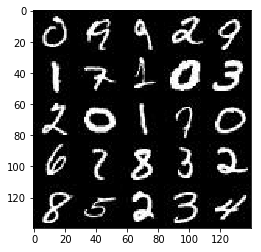

In [52]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

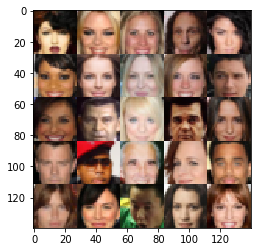

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    x_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='lr')
    return x_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [57]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement discriminator using batch normalization and leaky RELUs with a sigmoid activation on the fully connected output layer
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer 28x28xchannels
        conv1 = tf.layers.conv2d(images, 64, (5,5), strides=2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1)
        # output 14x14x64
        
        # set batch norm to training mode b/c we won't use the discriminator for inference
        conv2 = tf.layers.conv2d(conv1, 128, (5,5), strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        # output 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, (5,5), strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        # 7x7x256
        
        conv4 = tf.layers.conv2d(conv3, 512, (5,5), strides=2, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha*conv4, conv4)
        # 7x7x512
        
        # flatten output and return output and logits
        flat = tf.reshape(conv2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
# confirm transposed convolution dimensions
testx1 = tf.layers.dense(tf.zeros((100,1)), 7*7*512) 
print(testx1.shape)
testx1 = tf.reshape(testx1, (-1, 7, 7, 512))
print(testx1.shape)
x2test = tf.layers.conv2d_transpose(testx1, 256, 5, strides=2, padding='same')
print(x2test.shape)
x3test = tf.layers.conv2d_transpose(x2test, 128, 5, 1, padding='same')
print(x3test.shape)
logitstest = tf.layers.conv2d_transpose(x3test, 3, 5, strides=2, padding='same')
print(logitstest.shape)
outtest = tf.tanh(logitstest)
print(outtest.shape)

(100, 25088)
(100, 7, 7, 512)
(100, 14, 14, 256)
(100, 14, 14, 128)
(100, 28, 28, 3)
(100, 28, 28, 3)


In [59]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Use of "not is_train" to set variable reuse learned from @rahul_ahuja's forum post
    # https://discussions.udacity.com/t/generator-function-tf-variable-scope-called-with-wrong-arguments/397900
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Make first layer fully connected, deep and narrow
        x1 = tf.layers.dense(z, 7*7*512) 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # output 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # output 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # output 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # output 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_outputs = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_outputs_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_outputs_fake, d_logits_fake = discriminator(g_outputs, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_outputs_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_outputs_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_outputs_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL

why do the example_z inputs range from (-1, 1) when the MNIST and celeba data has been scaled to (-0.5, 0.5)?
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [63]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # create new graph each time train function is called
    # tf.reset_default_graph()
    # Get input placeholders
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Get discriminator and generator losses
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Get outputs
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # set up batch counter and loss tracker
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #print(batch_images.dtype)
                # rescale batch images from (-0.5, 0.5) to (-1,1). Must be scaled from (-1,1) to match tanh outputs.
                batch_images = batch_images*2
                # create z inputs from random noise. 
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                #print(batch_z.dtype)
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # show losses every 25 batches
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                   # losses.append((train_loss_d, train_loss_g))
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show losses and generator output every 100 batches
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
    return
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6818... Generator Loss: 0.1439
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.3508
Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.4379
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.7722


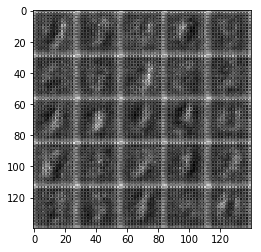

Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6303


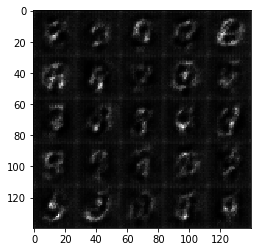

Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.3590


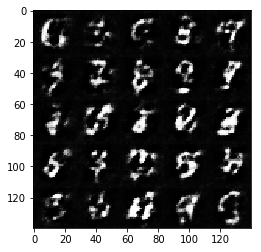

Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 0.8375


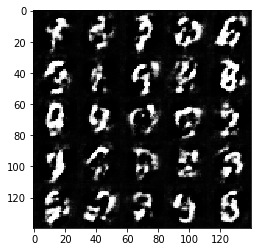

Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.5351
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.9767
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.4519
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.4946


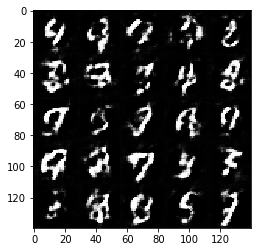

Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 1.2051
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 1.0755


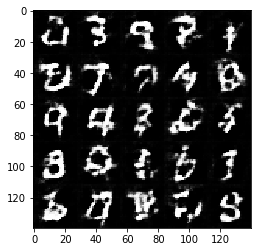

Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 1.1915
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 1.0788


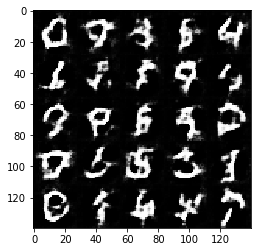

Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 1.1545


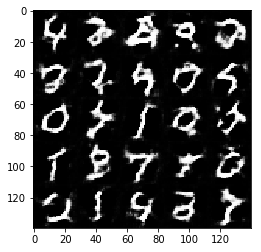

Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.4888... Generator Loss: 0.3340
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.6044


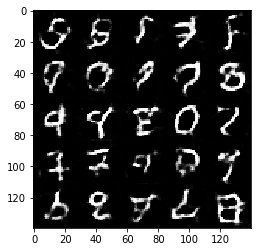

Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 1.0031


In [64]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2408... Generator Loss: 0.0318
Epoch 1/1... Discriminator Loss: 2.4053... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.8548


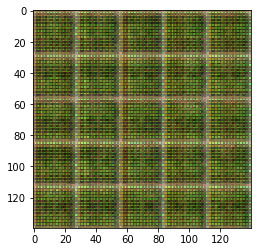

Epoch 1/1... Discriminator Loss: 1.9198... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.8608... Generator Loss: 0.5272


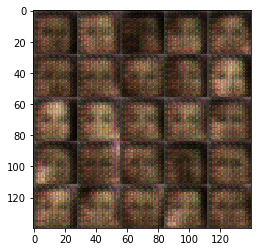

Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.9026... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7498


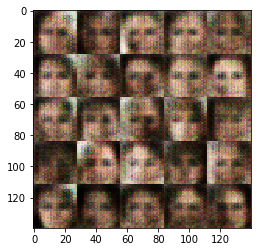

Epoch 1/1... Discriminator Loss: 1.6568... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6464


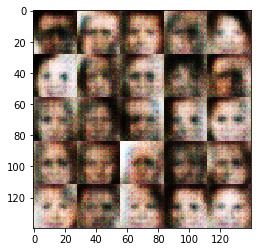

Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7408


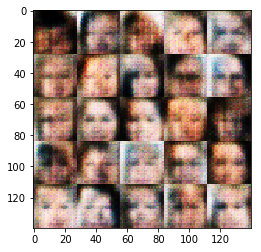

Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6322


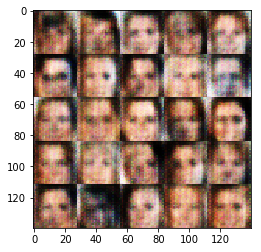

Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7023


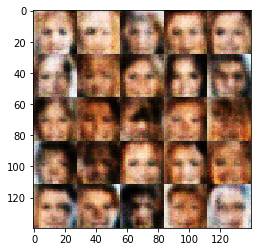

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8484


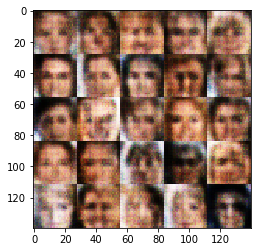

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6464


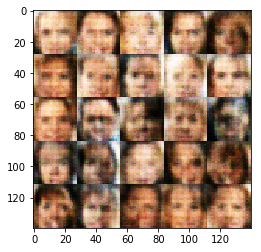

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6857


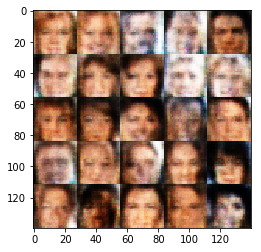

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0800


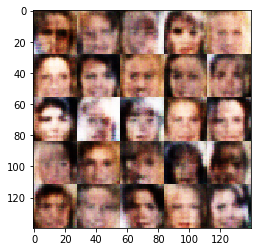

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.8343... Generator Loss: 0.2716
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5444


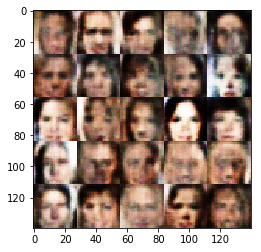

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.6547


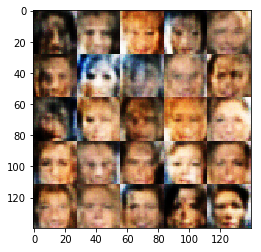

Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.9958
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.1710


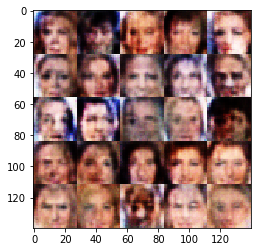

Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.8459... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.7025


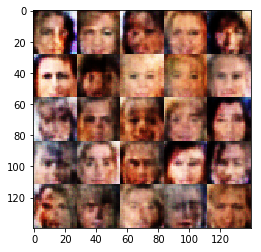

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.5086


In [65]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.